# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [1]:
import neuro_op as nop
import matplotlib.pyplot as plt

# import networkx as nx
import numpy as np
import scipy.stats as st

In [2]:
N_beliefs = 500

nodes, G, beliefs, world, N_events, t_end = nop.run_model(
    N_nodes=100,
    N_neighbours=3,
    N_beliefs=500,
    belief_min=-50,
    belief_max=50,
    log_priors=np.zeros(N_beliefs),
    likelihood=st.norm(loc=0, scale=5),
    world_dist=st.norm(loc=0, scale=5),
    h=1,
    r=0,
    t_max=10000,
)

print(f"Number of events: {N_events}")

Number of events: 10002


## Data analysis

After simulating the network with $h=1, r=0$ (meaning nodes communicating with the central node only), some simple analysis steps follow.



In [3]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
plt.rcParams.update(
    {
        "font.size": 20,
        "legend.loc": "upper right",
    }
)

#### Data analysis 1

Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


Text(0, 0.5, '$p(\\mu|x_i)$')

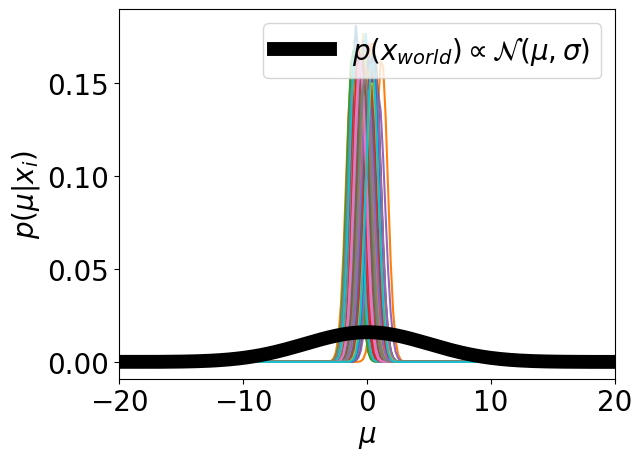

In [4]:
for i in range(len(nodes)):
    plt.plot(nodes[0].beliefs, nop.logpdf_to_pdf(nodes[i].log_probs))
    plt.xlim([-20, 20])
plt.plot(
    beliefs,
    nop.logpdf_to_pdf(world.log_probs),
    color="black",
    linewidth=10,
    label="$p(x_{world}) \propto \mathcal{N}(\mu,\sigma)$",
)
plt.legend()
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu|x_i)$")

#### Data analysis 2

Each node executes posterior predictive distribution sampling to generate a forecast of expected future data.

For some eye-balling analysis, histograms of `world_dist`'s and some nodes' PPD samples are plotted.

In [9]:
# Define parameters of data analysis
N_bins = 50  # go for uneven bin number to have a bin centered on 0
opinion_range = [-20, 20]  # chosen by experience, no formal reasoning

# Generate posterior predictive distributions (PPDs) for each node by generating ppd samples and binning them into histograms
ppd_samples = [
    nop.ppd_Gaussian_mu(node.beliefs, node.log_probs, 10000) for node in nodes
    ]


ppds = [  # PPD stored as histograms. Each histogram is a tuple (counts, bin_edges).
    np.histogram(
        i,
        bins=N_bins,
        range=opinion_range,
    )
    for i in ppd_samples
]

ppd_world = np.histogram(
    world.diary_out,
    bins=N_bins,
    range=opinion_range,
)

world_binned = nop.dist_binning(world.likelihood, N_bins, opinion_range)

# Save the centre of each node's bin with most samples.
# We then assume 'centres of each node's bin with most samples' == 'maximum likelihood estimates (MLEs) of each node')
argmax = np.argmax(ppd_world[0])
mu_world = (ppd_world[1][argmax] + ppd_world[1][argmax + 1]) / 2

argmax = [np.argmax(ppds_hist[0]) for ppds_hist in ppds]
mu_nodes = [
    (hist_data[1][i] + hist_data[1][i + 1]) / 2 for hist_data, i in zip(ppds, argmax)
]

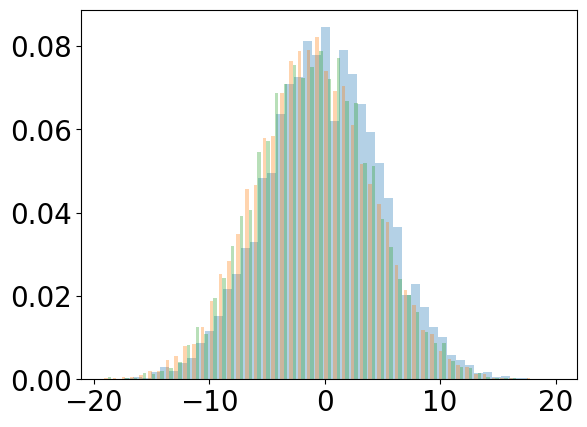

In [6]:
for i in [world.diary_out, ppd_samples[:2]]:
    plt.hist(i, bins=N_bins, density=True, alpha=1/3)

Mean KL divergence:	 0.007210374493766132
Mean linear p-distance:	 1.3519999999999999
Mean quad. p-distance:	 2.5407999999999986


/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:130: RuntimeWarning: divide by zero encountered in log
  terms = P * np.log(P / Q)
/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:130: RuntimeWarning: invalid value encountered in multiply
  terms = P * np.log(P / Q)


(array([24., 25., 16., 10.,  6.,  4.,  1.,  2.,  1.,  0.,  1.,  2.,  0.,
         0.,  3.,  2.,  0.,  0.,  1.,  2.]),
 array([0.00137424, 0.00295678, 0.00453933, 0.00612187, 0.00770441,
        0.00928695, 0.01086949, 0.01245203, 0.01403457, 0.01561711,
        0.01719965, 0.01878219, 0.02036473, 0.02194727, 0.02352981,
        0.02511235, 0.02669489, 0.02827743, 0.02985997, 0.03144251,
        0.03302505]),
 <BarContainer object of 20 artists>)

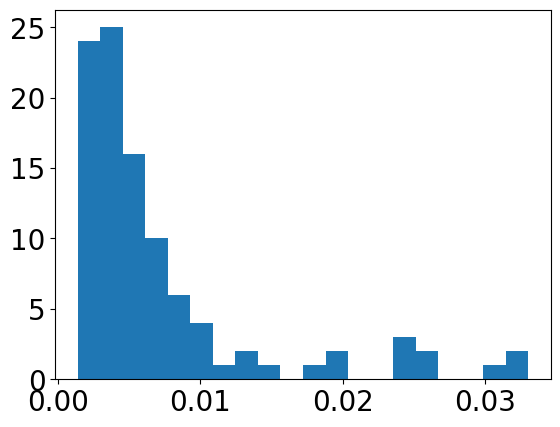

In [7]:
kl_divs = []
for i in ppds:
    P_sampled = i[0] / np.sum(i[0])
    kl_divs.append(nop.kl_divergence(P_sampled, world_binned))

print(f"Mean KL divergence:\t {np.mean(kl_divs)}")
print(f"Mean linear p-distance:\t {nop.p_distances(mu_nodes, mu_world, p=1)/len(nodes)}")
print(f"Mean quad. p-distance:\t {nop.p_distances(mu_nodes, mu_world, p=2)/len(nodes)}")
plt.hist(kl_divs, bins=20)


In [10]:
world_binned

array([2.98478040e-05, 5.51033120e-05, 9.91627037e-05, 1.73949982e-04,
       2.97444416e-04, 4.95784209e-04, 8.05536136e-04, 1.27580077e-03,
       1.96963711e-03, 2.96411552e-03, 4.34820094e-03, 6.21769884e-03,
       8.66673224e-03, 1.17756995e-02, 1.55963763e-02, 2.01356833e-02,
       2.53404735e-02, 3.10862822e-02, 3.71730811e-02, 4.33305358e-02,
       4.92340197e-02, 5.45308509e-02, 5.88741980e-02, 6.19602966e-02,
       6.35634892e-02, 6.35634892e-02, 6.19602966e-02, 5.88741980e-02,
       5.45308509e-02, 4.92340197e-02, 4.33305358e-02, 3.71730811e-02,
       3.10862822e-02, 2.53404735e-02, 2.01356833e-02, 1.55963763e-02,
       1.17756995e-02, 8.66673224e-03, 6.21769884e-03, 4.34820094e-03,
       2.96411552e-03, 1.96963711e-03, 1.27580077e-03, 8.05536136e-04,
       4.95784209e-04, 2.97444416e-04, 1.73949982e-04, 9.91627037e-05,
       5.51033120e-05, 2.98478040e-05])